<a href="https://colab.research.google.com/github/eunzzae/Study_NLP/blob/main/231205_%EC%8B%A4%EC%8A%B5_%5BChapter_6%5D_%ED%8C%8C%EC%9D%B8_%ED%8A%9C%EB%8B%9D_%EC%8B%A4%EC%8A%B5_%EB%B0%8F_%EA%B2%B0%EA%B3%BC_%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 파인 튜닝 실습 및 결과 분석

## Introduction
**Chapter 6. 자연어처리를 위한 모델 학습** 강의의 **파인 튜닝 실습 및 결과 분석** 강의입니다.

이번 실습에서는 (1) SKTBrain이 공개한 KoBERT를 네이버 영화 리뷰 감정 분석 데이터셋(nsmc)으로 파인튜닝하고,

(2) 파인튜닝한 모델의 감정 분류 작업에 대한 성능과 결과를 분석해보겠습니다.

In [1]:
!pip install mxnet
!pip install gluonnlp pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch

In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-br8rq203/kobert-tokenizer_73bbd9a2127e443aab797c8fb28fcf25
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-br8rq203/kobert-tokenizer_73bbd9a2127e443aab797c8fb28fcf25
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 47a69af87928fc24e20f571fe10c3cc9dd9af9a3
  Preparing metadata (setup.py) ... done


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

## 1. KoBERT 모델 불러오기

오늘 실습에는 SKTBrain에서 공개한 KoBERT-Transformers 모델을 사용합니다!

KoBERT 모델은 SKTBrain에서 공개한 한국어 데이터로 사전학습한 BERT 모델로,

google의 [multi-lingual BERT](https://github.com/google-research/bert/blob/master/multilingual.md) 성능의 한계를 극복하기 위해 공개되었습니다.

KoBERT-Transformers 모델은 KoBERT를 Huggingface.co 기반으로 사용할 수 있게 Wrapping 작업을 진행한 모델입니다.

**KoBERT** : https://github.com/SKTBrain/KoBERT

**KoBERT-Transformers**: https://github.com/monologg/KoBERT-Transformers

In [4]:
# ★ Hugging Face를 통한 모델 및 토크나이저 Import
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
# GPU 사용 시
device = torch.device("cuda:0")

In [6]:
# ★
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


In [7]:
!wget https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
!wget https://www.dropbox.com/s/977gbwh542gdy94/ratings_test.txt?dl=1

--2023-12-06 04:16:51--  https://www.dropbox.com/s/374ftkec978br3d/ratings_train.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/374ftkec978br3d/ratings_train.txt [following]
--2023-12-06 04:16:52--  https://www.dropbox.com/s/dl/374ftkec978br3d/ratings_train.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc84a5a2956fb72054bd0f9a2872.dl.dropboxusercontent.com/cd/0/get/CI0amzI90_FMnjdz1gaglxJfwJCmGG2D-gmH03rV9nX1Ojx-ybKgW_g8tqB2TsInRD3fm6dNPw_XVssFth4DxFEuuAh99WIneX0hP7UpfT9WltuT5-pDlOS4KpJUuZMbxmkFUlYd0w06KlG1F5SYH3nx/file?dl=1# [following]
--2023-12-06 04:16:52--  https://uc84a5a2956fb72054bd0f9a2872.dl.dropboxusercontent.com/cd/0/get/CI0amzI90_FMnjdz1gaglxJfwJCmGG2D-gmH03rV9nX1Ojx-ybKgW_g8tqB2TsInRD3fm6dNPw_XVssFth

이번 실습에서는 GluonNLP라는 툴킷을 사용하여 코드를 간단하게 구성해볼건데요,

[GluonNLP는](https://pypi.org/project/gluonnlp/) 자연어처리(NLP)의 연구 속도를 높이는데 도움이 되는 자연어 전처리 및 데이터셋 로드 과정을 추상화해주는 툴킷입니다.

다음의 링크에서 [GluonNLP](https://github.com/dmlc/gluon-nlp#quick-start-guide)의 quick start guide 혹은 [glounnlp.data](https://nlp.gluon.ai/api/modules/data.html)의 사용 예제를 확인해보셔도 좋을 것 같습니다!

In [8]:
import gluonnlp as nlp

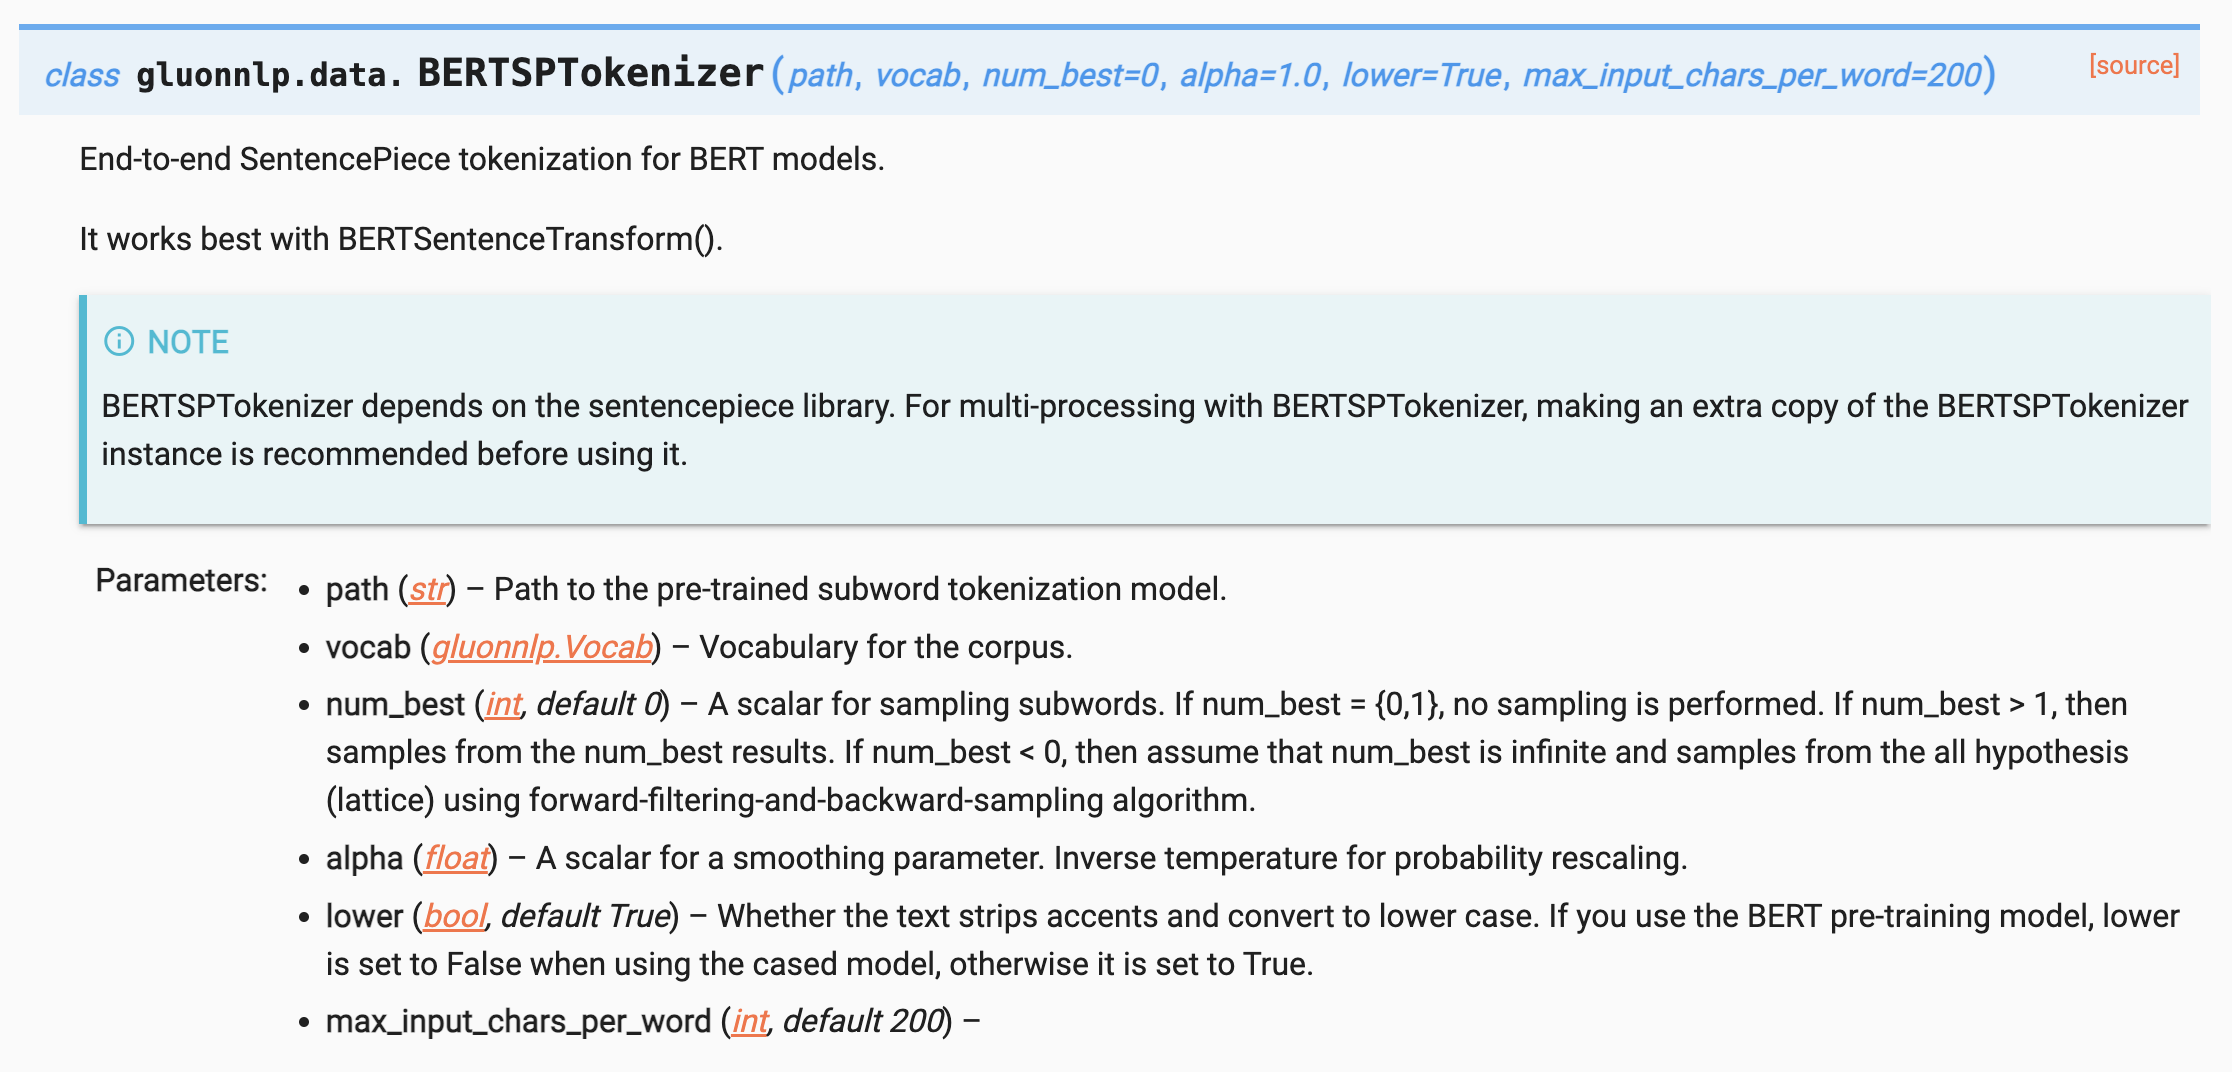

In [9]:
tokenizer = tokenizer.tokenize
bert_tokenizer = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

## 2. 데이터셋 로드하기

본 실습에서는 네이버의 한국어 영화 데이터셋([nsmc](https://github.com/e9t/nsmc))을 사용하여, 감성 분류 작업을 학습합니다.

해당 데이터셋은 [네이버 영화 리뷰 데이터셋](https://movie.naver.com/movie/point/af/list.naver)을 크롤링하여 제작되었으며,

데이터 세트 구성은 [Large movie review 데이터셋](http://ai.stanford.edu/~amaas/data/sentiment/) 에 언급된 방법을 기반으로 구축되었습니다.

### 2.1. 데이터셋 특징

각 파일은 세 개의 열로 구성됩니다. id, document,label

*   **id**: 네이버에서 제공하는 리뷰 아이디
*   **document**: 실제 리뷰
*   **label**: 리뷰의 감성 class 레이블입니다. (0: negative, 1: positive)

데이터셋 내 데이터 열은 탭으로 구분됩니다(예: .tsv형식, 그러나 파일 확장자는 .txt초보자가 쉽게 액세스할 수 있도록 함)



데이터셋은 총 200,000개의 리뷰로 구성되어 있으며, 파일은 각각 다음과 같습니다.

*   **ratings.txt**: 전체 200K 리뷰
*   **ratings_test.txt**: 테스트를 위해 구축된 50,000개의 리뷰
*   **ratings_train.txt**: 교육용 리뷰 150,000개


*   모든 리뷰는 140자 미만입니다.
*   각 감정 클래스는 동일하게 샘플링되며(예: 무작위 추측의 정확도는 50%),
*   중립 리뷰(원래 평점 5-8의 리뷰)는 제외됩니다.

따라서, 최종 데이터셋의 레이블 별 분포는 다음과 같습니다.
*   100,000개의 부정적인 리뷰(원래 평점 1-4의 리뷰)
*   100,000개의 긍정적인 리뷰(원래 평점 9-10의 리뷰)


In [10]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

In [11]:
!wget -O .cache/ratings_train.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_train.txt
!wget -O .cache/ratings_test.txt http://skt-lsl-nlp-model.s3.amazonaws.com/KoBERT/datasets/nsmc/ratings_test.txt

.cache/ratings_train.txt: No such file or directory
.cache/ratings_test.txt: No such file or directory


*   **첫 번째 파라미터**: "tsv 파일명"
*   **field_indices** : [학습시킬 데이터의 index, 데이터 레이블의 index]
*   **num_discard_samples** : 데이터 상단에서 제외할 row의 개수 (default = 0)

In [12]:
raw_train_dataset = nlp.data.TSVDataset("ratings_train.txt?dl=1", field_indices=[1,2], num_discard_samples=1)
raw_test_dataset = nlp.data.TSVDataset("ratings_test.txt?dl=1", field_indices=[1,2], num_discard_samples=1)

In [13]:
raw_train_dataset[0]

['아 더빙.. 진짜 짜증나네요 목소리', '0']

BERT 모델에서 사용할 데이터셋의 클래스를 정의합니다

In [14]:
# ★
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, vocab, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

데이터셋과 관련된 파라미터를 정의합니다.

In [15]:
# Setting parameters
max_len = 64
batch_size = 64
# warmup_ratio = 0.1
# num_epochs = 5
# max_grad_norm = 1
# log_interval = 200
# learning_rate =  5e-5

In [16]:
# ★

train_dataset = BERTDataset(raw_train_dataset, 0, 1, bert_tokenizer, vocab, max_len, True, False)
test_dataset = BERTDataset(raw_test_dataset, 0, 1, bert_tokenizer, vocab, max_len, True, False)

In [17]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=5)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## 3. BERT with classifier 모델 클래스 정의

네이버 영화 감성 분류 데이터셋은 Binary classification 작업이므로,

입력 리뷰 데이터에 대해 binary로 레이블을 예측할 수 있어야 합니다.

따라서, 출력 차원이 2인 classifier를 BERT 모델에 추가해줘야 합니다!

먼저, 모델 클래스 정의에 필요한 파라미터를 정의해줍니다.

In [18]:
dropout_rate = 0.2

In [19]:
class BERTClassifier(nn.Module):
  def __init__(
    self,
    bert,
    hidden_size = 768,
    num_classes=2,
    dropout=None,
    params=None
  ):
    super(BERTClassifier, self).__init__()
    self.bert = bert
    self.dropout = dropout

    # classification 작업을 수행하기 위해 output을 num_classes로 projection하는 레이어를 추가합니다.
    self.classifier = nn.Linear(hidden_size, num_classes)

    if dropout:
      self.dropout = nn.Dropout(p=dropout)

  def gen_attention_mask(self, token_ids, valid_length):
    attention_mask = torch.zeros_like(token_ids)
    for i, v in enumerate(valid_length):
      attention_mask[i][:v] = 1
    return attention_mask.float()

  def forward(self, token_ids, valid_length, segment_ids):
    attention_mask = self.gen_attention_mask(token_ids, valid_length)

    # BERT 모델에서 나온 출력의 CLS 토큰을 반환합니다
    _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))

    if self.dropout:
      output = self.dropout(pooler)
    else:
      output = pooler

    predicted = self.classifier(output)

    return predicted

In [20]:
# GPU
device = torch.device("cuda:0")

In [21]:
model = BERTClassifier(bertmodel, dropout=dropout_rate).to(device)

## 4. 학습 파라미터 설정

In [22]:
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
import torch.optim as optim
from tqdm.notebook import tqdm

안정적인 학습을 위해 다음과 같이 학습 파라미터를 설정합니다.

In [23]:
warmup_ratio = 0.1
num_epochs = 1
max_grad_norm = 1
learning_rate =  5e-5

설정된 파라미터에 따라 weight decay 및 optimizer를 정의합니다.

In [24]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [25]:
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
total_steps = len(train_dataloader) * num_epochs
warmup_step = int(total_steps * warmup_ratio)

In [27]:
print(f"전체 학습 스텝은 다음과 같습니다: {total_steps}")
print(f"전체 학습 스텝 중 warmup 스텝은 다음과 같습니다: {warmup_step}")

전체 학습 스텝은 다음과 같습니다: 2344
전체 학습 스텝 중 warmup 스텝은 다음과 같습니다: 234


설정된 파라미터에 따라 learning rate scheduler를 설정합니다.

In [28]:
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=total_steps)

## 5. 모델 학습 및 분석

본 학습에서는 다음과 같이 정확도로 모델의 성능을 평가합니다.

In [29]:
def calc_accuracy(X,Y):
  max_vals, max_indices = torch.max(X, 1)
  train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
  return train_acc

추가로, 테스트 데이터셋에 대한 confusion matrix를 출력하기 위해 다음과 같은 함수를 정의합니다.

In [30]:
import matplotlib.pyplot as plt
import itertools

from sklearn.metrics import confusion_matrix

In [31]:
def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues')):
    plt.imshow(c_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []

    for k in range(len(c_matrix)):
        n = sum(c_matrix[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)

    plt.xticks(marks, labels)
    plt.yticks(marks, nlabels)

    thresh = c_matrix.max() / 2.

    for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
      plt.text(j, i, c_matrix[i, j], horizontalalignment="center", color="white" if c_matrix[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

<ipython-input-31-f60ea33bfa7a>:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def plot_confusion_matrix(c_matrix, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues')):


다음과 같이 모델 학습 코드를 작성합니다!

200 스텝마다 결과를 출력하도록 합니다.

In [32]:
log_interval = 200

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/2344 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 0.7018393874168396 train acc 0.484375
epoch 1 batch id 201 loss 0.38261011242866516 train acc 0.7029695273631841
epoch 1 train acc 0.7029695273631841


  0%|          | 0/782 [00:00<?, ?it/s]

epoch 1 test acc 0.8355654761904762


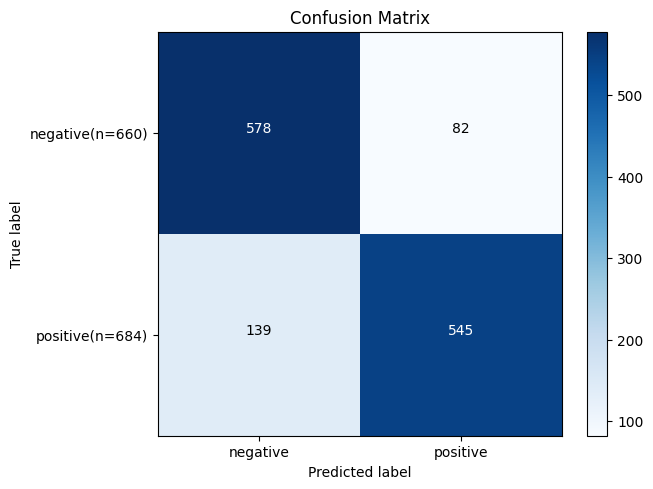

In [33]:
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0

    model.train()

    for batch_id, (token_ids, seq_length, segment_ids, label) in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
      optimizer.zero_grad()

      token_ids = token_ids.long().to(device)
      segment_ids = segment_ids.long().to(device)
      label = label.long().to(device)

      predict = model(token_ids, seq_length, segment_ids)
      loss = loss_fn(predict, label)
      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

      # optimizer와 scheduler를 스텝에 따라 업데이트합니다.
      optimizer.step()
      scheduler.step()

      train_acc += calc_accuracy(predict, label)

      if batch_id % log_interval == 0:
        print("epoch {} batch id {} loss {} train acc {}".format(
          e+1, batch_id+1,
          loss.data.cpu().numpy(),
          train_acc / (batch_id+1)
          )
        )

      if batch_id == log_interval:
        # 빠른 실습을 위해 200 step만 학습
        break

    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))

    # 한 에폭의 학습이 종료된 후, 테스트 데이터셋에 대한 성능을 출력합니다.
    model.eval()

    total_label = []
    total_predict = []

    for batch_id, (token_ids, seq_length, segment_ids, label) in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        label = label.long().to(device)

        predict = model(token_ids, seq_length, segment_ids)
        test_acc += calc_accuracy(predict, label)

        predicted_label = torch.max(predict, 1)[1]

        total_label += label.tolist()
        total_predict += predicted_label.tolist()

        # 빠른 실습을 위해 20 step만 평가
        if batch_id == 20:
          break

    # 테스트가 종료된 후, 테스트 데이터셋 전체 성능을 요약하여 출력
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

    # 테스트가 종료된 후, 테스트 데이터셋 전체 예측값에 대한 confusion matrix 출력
    test_confusion_matrix = confusion_matrix(total_label, total_predict)
    plot_confusion_matrix(test_confusion_matrix, labels=["negative", "positive"])